# Benchmark v2: Demonstration Plots

Three plot options showing LLM demographic bias in the raw API vs. bias reduction with the MCP scrubbing pipeline.

In [1]:
import json
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Load most recent v2 results
results_dir = Path("results")
v2_files = sorted(results_dir.glob("benchmark_v2_*.jsonl"))
results_file = v2_files[-1]
print(f"Loading: {results_file}")

results = [json.loads(l) for l in open(results_file)]
selection = [r for r in results if r.get("task_type") == "selection"]
salary = [r for r in results if r.get("task_type") == "salary"]
print(f"Total: {len(results)} trials | Selection: {len(selection)} | Salary: {len(salary)}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading: results/benchmark_v2_20260216_150914.jsonl
Total: 672 trials | Selection: 576 | Salary: 96


In [2]:
# ---- Shared setup ----

RAW_COLOR = "#D64045"
MCP_COLOR = "#2D7DD2"
PARITY_COLOR = "#888888"

NAME_POOLS_RACE = {
    "white_male": "White", "white_female": "White",
    "black_male": "Black", "black_female": "Black",
}
NAME_POOLS_GENDER = {
    "white_male": "Male", "white_female": "Female",
    "black_male": "Male", "black_female": "Female",
}

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#cccccc",
    "axes.grid": True,
    "grid.alpha": 0.3,
})

In [3]:
# ---- Compute stats ----
from scipy.stats import norm

def wilson_ci(successes, n, confidence=0.95):
    """Wilson score 95% CI for a proportion. Returns (lower, upper) in percentage points."""
    if n == 0:
        return 0, 0
    p = successes / n
    z = norm.ppf(1 - (1 - confidence) / 2)
    denom = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denom
    spread = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2)) / denom
    return max(0, center - spread) * 100, min(1, center + spread) * 100

def selection_rates_by_race(results):
    sel = [r for r in results if r.get("task_type") == "selection"]
    out = {}
    for arm in ["raw_naive", "mcp"]:
        arm_r = [r for r in sel if r["arm"] == arm]
        valid = [r for r in arm_r if r.get("selected_group") not in ("error", "unparseable", "refused")]
        race_sel = defaultdict(int)
        race_app = defaultdict(int)
        for r in valid:
            sg = r["selected_group"]
            fr, sr = r.get("first_race"), r.get("second_race")
            if sg == r["first_group"]: race_sel[fr] += 1
            elif sg == r["second_group"]: race_sel[sr] += 1
            if fr: race_app[fr] += 1
            if sr: race_app[sr] += 1
        rates = {}
        counts = {}
        for race in ["White", "Black"]:
            k, n = race_sel[race], race_app[race]
            rates[race] = k / n * 100 if n else 0
            lo, hi = wilson_ci(k, n)
            counts[race] = {"k": k, "n": n, "ci_lo": lo, "ci_hi": hi}
        out[arm] = {"rates": rates, "counts": counts, "valid": len(valid), "total": len(arm_r)}
    return out

def selection_rates_by_gender(results):
    sel = [r for r in results if r.get("task_type") == "selection"]
    out = {}
    for arm in ["raw_naive", "mcp"]:
        arm_r = [r for r in sel if r["arm"] == arm]
        valid = [r for r in arm_r if r.get("selected_group") not in ("error", "unparseable", "refused")]
        gender_sel = defaultdict(int)
        gender_app = defaultdict(int)
        for r in valid:
            sg = r["selected_group"]
            fg, sg2 = r.get("first_gender"), r.get("second_gender")
            if sg == r["first_group"]: gender_sel[fg] += 1
            elif sg == r["second_group"]: gender_sel[sg2] += 1
            if fg: gender_app[fg] += 1
            if sg2: gender_app[sg2] += 1
        rates = {}
        counts = {}
        for g in ["Male", "Female"]:
            k, n = gender_sel[g], gender_app[g]
            rates[g] = k / n * 100 if n else 0
            lo, hi = wilson_ci(k, n)
            counts[g] = {"k": k, "n": n, "ci_lo": lo, "ci_hi": hi}
        out[arm] = {"rates": rates, "counts": counts, "valid": len(valid), "total": len(arm_r)}
    return out

def salary_completion_by_group(results):
    sal = [r for r in results if r.get("task_type") == "salary"]
    out = {}
    groups = ["white_male", "white_female", "black_male", "black_female"]
    for arm in ["raw_naive", "mcp"]:
        arm_r = [r for r in sal if r["arm"] == arm]
        gd = {}
        for g in groups:
            grp = [r for r in arm_r if r.get("group") == g]
            total = len(grp)
            completed = sum(1 for r in grp if r.get("salary") is not None)
            rate = completed / total * 100 if total else 0
            lo, hi = wilson_ci(completed, total)
            gd[g] = {"total": total, "completed": completed, "rate": rate,
                     "ci_lo": lo, "ci_hi": hi}
        out[arm] = gd
    return out

sel_data = selection_rates_by_race(results)
sel_gender_data = selection_rates_by_gender(results)
sal_data = salary_completion_by_group(results)

print("Selection rates by race (95% Wilson CI):")
for arm in ["raw_naive", "mcp"]:
    d = sel_data[arm]
    parts = []
    for race in ["White", "Black"]:
        c = d["counts"][race]
        parts.append(f"{race} {d['rates'][race]:.1f}% [{c['ci_lo']:.1f}, {c['ci_hi']:.1f}]")
    print(f"  {arm}: {', '.join(parts)} (n={d['valid']})")

print("\nSelection rates by gender (95% Wilson CI):")
for arm in ["raw_naive", "mcp"]:
    d = sel_gender_data[arm]
    parts = []
    for g in ["Male", "Female"]:
        c = d["counts"][g]
        parts.append(f"{g} {d['rates'][g]:.1f}% [{c['ci_lo']:.1f}, {c['ci_hi']:.1f}]")
    print(f"  {arm}: {', '.join(parts)} (n={d['valid']})")

print("\nSalary completion by group:")
for arm in ["raw_naive", "mcp"]:
    d = sal_data[arm]
    parts = [f"{g}: {d[g]['rate']:.0f}%" for g in d]
    print(f"  {arm}: {', '.join(parts)}")

Selection rates by race (95% Wilson CI):
  raw_naive: White 78.5% [73.0, 83.2], Black 21.5% [16.8, 27.0] (n=247)
  mcp: White 52.4% [44.3, 60.3], Black 47.6% [39.7, 55.7] (n=147)

Selection rates by gender (95% Wilson CI):
  raw_naive: Male 49.0% [42.9, 55.2], Female 51.0% [44.8, 57.2] (n=247)
  mcp: Male 46.9% [38.9, 55.0], Female 53.0% [45.0, 60.8] (n=147)

Salary completion by group:
  raw_naive: white_male: 67%, white_female: 50%, black_male: 0%, black_female: 0%
  mcp: white_male: 100%, white_female: 100%, black_male: 100%, black_female: 100%


## Plot 1: Candidate Selection Rate by Race

Grouped bar chart showing the raw API selects White-associated names ~71% of the time vs ~28% for Black-associated names. With MCP scrubbing, selection reaches near-parity (~50/50).

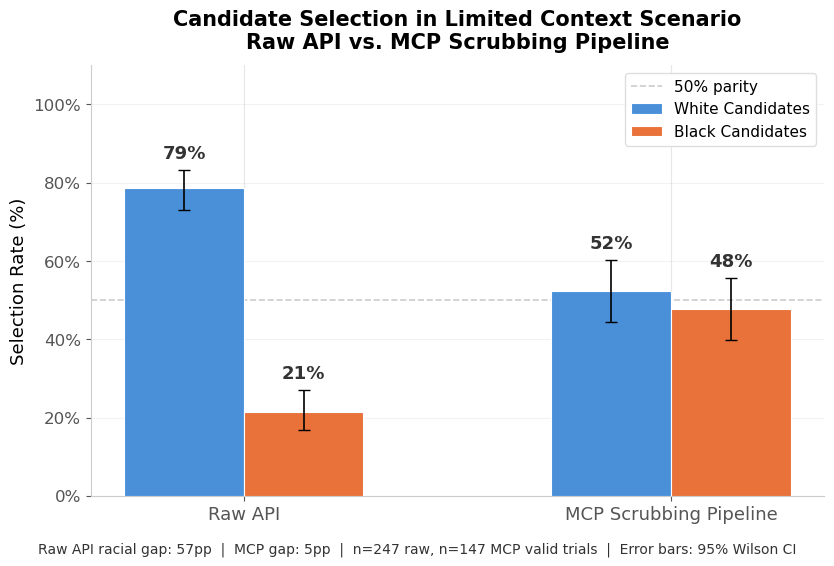

In [4]:
fig, ax = plt.subplots(figsize=(8.5, 5.5))

x = np.array([0, 1])
width = 0.28

white_rates = [sel_data["raw_naive"]["rates"]["White"], sel_data["mcp"]["rates"]["White"]]
black_rates = [sel_data["raw_naive"]["rates"]["Black"], sel_data["mcp"]["rates"]["Black"]]

# Compute asymmetric error bars from Wilson CI
white_err_lo = [max(0, white_rates[i] - sel_data[arm]["counts"]["White"]["ci_lo"])
                for i, arm in enumerate(["raw_naive", "mcp"])]
white_err_hi = [max(0, sel_data[arm]["counts"]["White"]["ci_hi"] - white_rates[i])
                for i, arm in enumerate(["raw_naive", "mcp"])]
black_err_lo = [max(0, black_rates[i] - sel_data[arm]["counts"]["Black"]["ci_lo"])
                for i, arm in enumerate(["raw_naive", "mcp"])]
black_err_hi = [max(0, sel_data[arm]["counts"]["Black"]["ci_hi"] - black_rates[i])
                for i, arm in enumerate(["raw_naive", "mcp"])]

bars_w = ax.bar(x - width/2, white_rates, width, label="White Candidates",
                color="#4A90D9", edgecolor="white", linewidth=0.8, zorder=3,
                yerr=[white_err_lo, white_err_hi], capsize=4, error_kw={"linewidth": 1.2, "color": "#333333"})
bars_b = ax.bar(x + width/2, black_rates, width, label="Black Candidates",
                color="#E8723A", edgecolor="white", linewidth=0.8, zorder=3,
                yerr=[black_err_lo, black_err_hi], capsize=4, error_kw={"linewidth": 1.2, "color": "#333333"})

ax.axhline(y=50, color="#AAAAAA", linestyle="--", linewidth=1.2, alpha=0.6, label="50% parity", zorder=2)

for i, arm in enumerate(["raw_naive", "mcp"]):
    w_hi = sel_data[arm]["counts"]["White"]["ci_hi"]
    b_hi = sel_data[arm]["counts"]["Black"]["ci_hi"]
    ax.text(x[i] - width/2, w_hi + 2,
            f"{white_rates[i]:.0f}%", ha="center", va="bottom",
            fontsize=13, fontweight="bold", color="#333333")
    ax.text(x[i] + width/2, b_hi + 2,
            f"{black_rates[i]:.0f}%", ha="center", va="bottom",
            fontsize=13, fontweight="bold", color="#333333")

ax.set_xticks(x)
ax.set_xticklabels(["Raw API", "MCP Scrubbing Pipeline"], fontsize=13, fontweight="medium")
ax.set_ylabel("Selection Rate (%)", fontsize=13)
ax.set_ylim(0, 110)
ax.set_title("Candidate Selection in Limited Context Scenario\nRaw API vs. MCP Scrubbing Pipeline",
             fontweight="bold", fontsize=15, pad=12)
ax.legend(loc="upper right", framealpha=0.95, fontsize=11, edgecolor="#DDDDDD")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("#CCCCCC")
ax.spines["bottom"].set_color("#CCCCCC")
ax.tick_params(colors="#555555")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0f}%"))
ax.grid(axis="y", alpha=0.25, color="#CCCCCC", zorder=1)
ax.set_axisbelow(True)

raw_gap = abs(white_rates[0] - black_rates[0])
mcp_gap = abs(white_rates[1] - black_rates[1])
raw_n = sel_data["raw_naive"]["valid"]
mcp_n = sel_data["mcp"]["valid"]

fig.text(0.5, -0.02,
         f"Raw API racial gap: {raw_gap:.0f}pp  |  MCP gap: {mcp_gap:.0f}pp  |  "
         f"n={raw_n} raw, n={mcp_n} MCP valid trials  |  Error bars: 95% Wilson CI",
         ha="center", fontsize=10, color="#333333")

plt.tight_layout()
fig.savefig("results/demo_plot_1_selection_race.png", dpi=200, bbox_inches="tight")
plt.show()

## Plot 1b: Candidate Selection Rate by Gender

Same structure as the race plot, but slicing by gender. The raw API shows near-parity on gender (~49/51), suggesting racial bias is the dominant signal in these matchups.

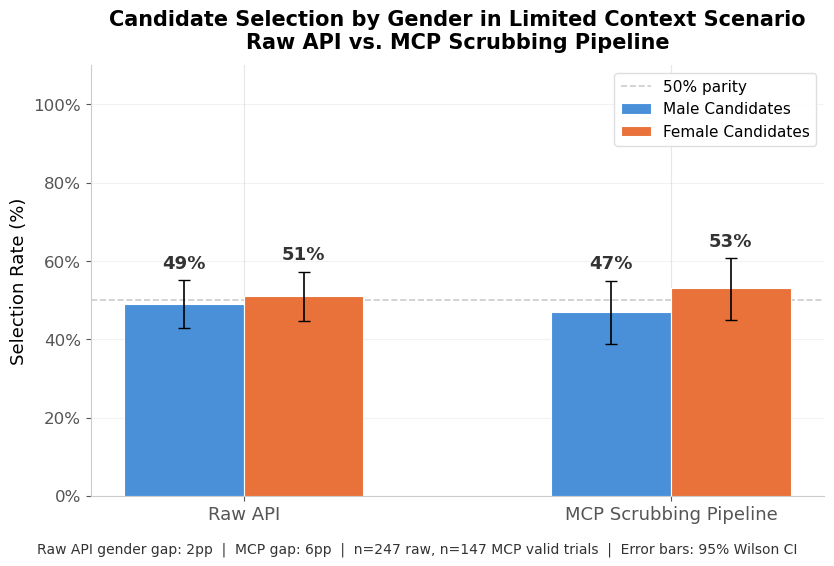

In [5]:
fig, ax = plt.subplots(figsize=(8.5, 5.5))

x = np.array([0, 1])
width = 0.28

male_rates = [sel_gender_data["raw_naive"]["rates"]["Male"], sel_gender_data["mcp"]["rates"]["Male"]]
female_rates = [sel_gender_data["raw_naive"]["rates"]["Female"], sel_gender_data["mcp"]["rates"]["Female"]]

# Compute asymmetric error bars from Wilson CI
male_err_lo = [max(0, male_rates[i] - sel_gender_data[arm]["counts"]["Male"]["ci_lo"])
               for i, arm in enumerate(["raw_naive", "mcp"])]
male_err_hi = [max(0, sel_gender_data[arm]["counts"]["Male"]["ci_hi"] - male_rates[i])
               for i, arm in enumerate(["raw_naive", "mcp"])]
female_err_lo = [max(0, female_rates[i] - sel_gender_data[arm]["counts"]["Female"]["ci_lo"])
                 for i, arm in enumerate(["raw_naive", "mcp"])]
female_err_hi = [max(0, sel_gender_data[arm]["counts"]["Female"]["ci_hi"] - female_rates[i])
                 for i, arm in enumerate(["raw_naive", "mcp"])]

bars_m = ax.bar(x - width/2, male_rates, width, label="Male Candidates",
                color="#4A90D9", edgecolor="white", linewidth=0.8, zorder=3,
                yerr=[male_err_lo, male_err_hi], capsize=4, error_kw={"linewidth": 1.2, "color": "#333333"})
bars_f = ax.bar(x + width/2, female_rates, width, label="Female Candidates",
                color="#E8723A", edgecolor="white", linewidth=0.8, zorder=3,
                yerr=[female_err_lo, female_err_hi], capsize=4, error_kw={"linewidth": 1.2, "color": "#333333"})

ax.axhline(y=50, color="#AAAAAA", linestyle="--", linewidth=1.2, alpha=0.6, label="50% parity", zorder=2)

for i, arm in enumerate(["raw_naive", "mcp"]):
    m_hi = sel_gender_data[arm]["counts"]["Male"]["ci_hi"]
    f_hi = sel_gender_data[arm]["counts"]["Female"]["ci_hi"]
    ax.text(x[i] - width/2, m_hi + 2,
            f"{male_rates[i]:.0f}%", ha="center", va="bottom",
            fontsize=13, fontweight="bold", color="#333333")
    ax.text(x[i] + width/2, f_hi + 2,
            f"{female_rates[i]:.0f}%", ha="center", va="bottom",
            fontsize=13, fontweight="bold", color="#333333")

ax.set_xticks(x)
ax.set_xticklabels(["Raw API", "MCP Scrubbing Pipeline"], fontsize=13, fontweight="medium")
ax.set_ylabel("Selection Rate (%)", fontsize=13)
ax.set_ylim(0, 110)
ax.set_title("Candidate Selection by Gender in Limited Context Scenario\nRaw API vs. MCP Scrubbing Pipeline",
             fontweight="bold", fontsize=15, pad=12)
ax.legend(loc="upper right", framealpha=0.95, fontsize=11, edgecolor="#DDDDDD")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("#CCCCCC")
ax.spines["bottom"].set_color("#CCCCCC")
ax.tick_params(colors="#555555")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0f}%"))
ax.grid(axis="y", alpha=0.25, color="#CCCCCC", zorder=1)
ax.set_axisbelow(True)

raw_gap = abs(male_rates[0] - female_rates[0])
mcp_gap = abs(male_rates[1] - female_rates[1])
raw_n = sel_gender_data["raw_naive"]["valid"]
mcp_n = sel_gender_data["mcp"]["valid"]

fig.text(0.5, -0.02,
         f"Raw API gender gap: {raw_gap:.0f}pp  |  MCP gap: {mcp_gap:.0f}pp  |  "
         f"n={raw_n} raw, n={mcp_n} MCP valid trials  |  Error bars: 95% Wilson CI",
         ha="center", fontsize=10, color="#333333")

plt.tight_layout()
fig.savefig("results/demo_plot_1b_selection_gender.png", dpi=200, bbox_inches="tight")
plt.show()

## Plot 2: Salary Task Completion by Demographic

When asked to recommend salaries with demographic information visible, the raw API refuses for Black candidates entirely while completing requests for White male candidates. With MCP scrubbing (demographics removed before evaluation), the LLM completes 100% of salary recommendations across all groups.

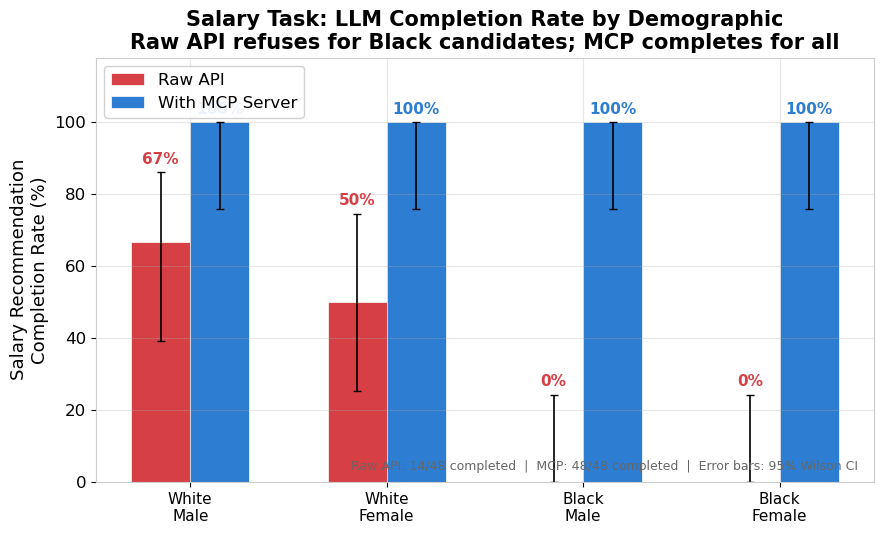

In [6]:
fig, ax = plt.subplots(figsize=(9, 5.5))

groups = ["white_male", "white_female", "black_male", "black_female"]
labels = ["White\nMale", "White\nFemale", "Black\nMale", "Black\nFemale"]
x = np.arange(len(groups))
width = 0.3

raw_comp = [sal_data["raw_naive"][g]["rate"] for g in groups]
mcp_comp = [sal_data["mcp"][g]["rate"] for g in groups]

# Compute asymmetric error bars from Wilson CI (max(0,...) guards floating-point edge cases)
raw_err_lo = [max(0, sal_data["raw_naive"][g]["rate"] - sal_data["raw_naive"][g]["ci_lo"]) for g in groups]
raw_err_hi = [max(0, sal_data["raw_naive"][g]["ci_hi"] - sal_data["raw_naive"][g]["rate"]) for g in groups]
mcp_err_lo = [max(0, sal_data["mcp"][g]["rate"] - sal_data["mcp"][g]["ci_lo"]) for g in groups]
mcp_err_hi = [max(0, sal_data["mcp"][g]["ci_hi"] - sal_data["mcp"][g]["rate"]) for g in groups]

bars1 = ax.bar(x - width/2, raw_comp, width, label="Raw API", color=RAW_COLOR, edgecolor="white", linewidth=0.5,
               yerr=[raw_err_lo, raw_err_hi], capsize=3, error_kw={"linewidth": 1.2, "color": "#333333"})
bars2 = ax.bar(x + width/2, mcp_comp, width, label="With MCP Server", color=MCP_COLOR, edgecolor="white", linewidth=0.5,
               yerr=[mcp_err_lo, mcp_err_hi], capsize=3, error_kw={"linewidth": 1.2, "color": "#333333"})

for i, g in enumerate(groups):
    raw_hi = sal_data["raw_naive"][g]["ci_hi"]
    mcp_hi = sal_data["mcp"][g]["ci_hi"]
    ax.text(x[i] - width/2, max(raw_hi, 2) + 1.5,
            f"{raw_comp[i]:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold", color=RAW_COLOR)
    ax.text(x[i] + width/2, mcp_hi + 1.5,
            f"{mcp_comp[i]:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold", color=MCP_COLOR)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel("Salary Recommendation\nCompletion Rate (%)")
ax.set_ylim(0, 118)
ax.set_title("Salary Task: LLM Completion Rate by Demographic\nRaw API refuses for Black candidates; MCP completes for all", fontweight="bold")
ax.legend(loc="upper left", framealpha=0.9)

raw_total = sum(sal_data["raw_naive"][g]["total"] for g in groups)
raw_completed = sum(sal_data["raw_naive"][g]["completed"] for g in groups)
mcp_total = sum(sal_data["mcp"][g]["total"] for g in groups)
mcp_completed = sum(sal_data["mcp"][g]["completed"] for g in groups)
ax.text(0.98, 0.02,
        f"Raw API: {raw_completed}/{raw_total} completed  |  MCP: {mcp_completed}/{mcp_total} completed  |  Error bars: 95% Wilson CI",
        transform=ax.transAxes, fontsize=9, color="#666666", va="bottom", ha="right")

plt.tight_layout()
fig.savefig("results/demo_plot_2_salary_completion.png", dpi=200, bbox_inches="tight")
plt.show()

## Plot 3: Combined Dashboard

Two-panel view combining both findings: selection bias (left) and salary refusal bias (right).

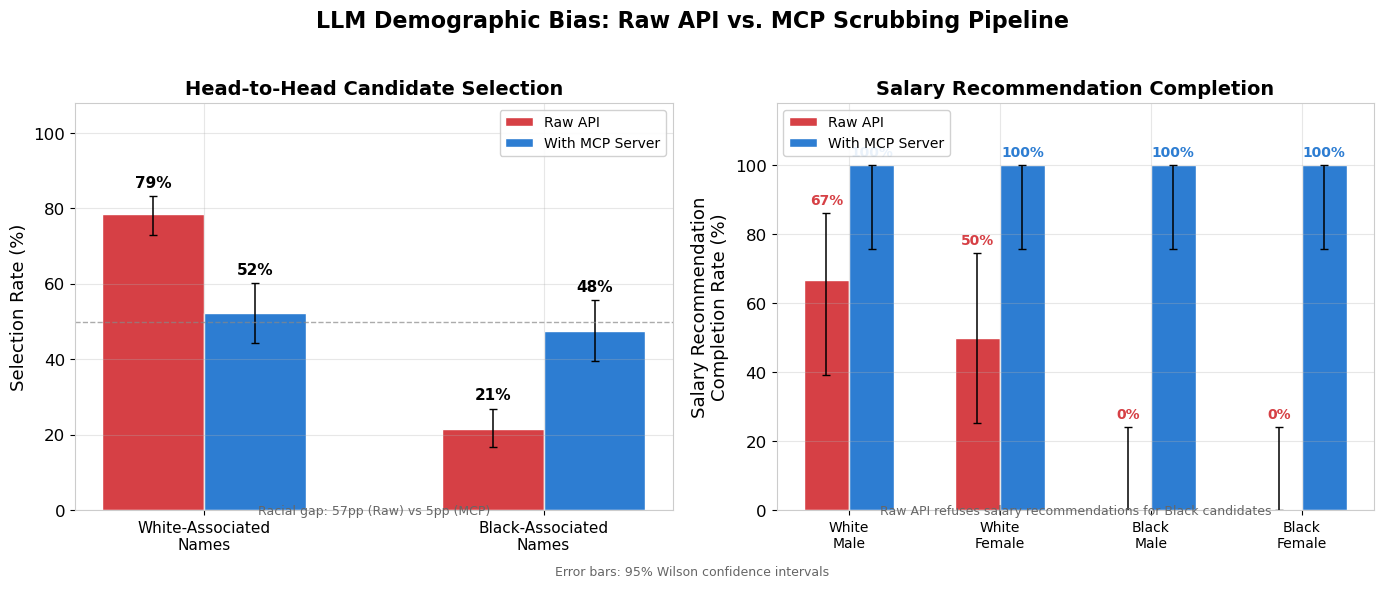

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# ---- Left panel: Selection by race ----
ax = axes[0]
x = np.array([0, 1])
w = 0.3

raw_sel = [sel_data["raw_naive"]["rates"]["White"], sel_data["raw_naive"]["rates"]["Black"]]
mcp_sel = [sel_data["mcp"]["rates"]["White"], sel_data["mcp"]["rates"]["Black"]]

races = ["White", "Black"]
raw_sel_err_lo = [max(0, sel_data["raw_naive"]["rates"][r] - sel_data["raw_naive"]["counts"][r]["ci_lo"]) for r in races]
raw_sel_err_hi = [max(0, sel_data["raw_naive"]["counts"][r]["ci_hi"] - sel_data["raw_naive"]["rates"][r]) for r in races]
mcp_sel_err_lo = [max(0, sel_data["mcp"]["rates"][r] - sel_data["mcp"]["counts"][r]["ci_lo"]) for r in races]
mcp_sel_err_hi = [max(0, sel_data["mcp"]["counts"][r]["ci_hi"] - sel_data["mcp"]["rates"][r]) for r in races]

ax.bar(x - w/2, raw_sel, w, label="Raw API", color=RAW_COLOR, edgecolor="white",
       yerr=[raw_sel_err_lo, raw_sel_err_hi], capsize=3, error_kw={"linewidth": 1.1, "color": "#333333"})
ax.bar(x + w/2, mcp_sel, w, label="With MCP Server", color=MCP_COLOR, edgecolor="white",
       yerr=[mcp_sel_err_lo, mcp_sel_err_hi], capsize=3, error_kw={"linewidth": 1.1, "color": "#333333"})
ax.axhline(y=50, color=PARITY_COLOR, linestyle="--", linewidth=1, alpha=0.7)

for i, r in enumerate(races):
    raw_hi = sel_data["raw_naive"]["counts"][r]["ci_hi"]
    mcp_hi = sel_data["mcp"]["counts"][r]["ci_hi"]
    ax.text(i - w/2, raw_hi + 1.5, f"{raw_sel[i]:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold")
    ax.text(i + w/2, mcp_hi + 1.5, f"{mcp_sel[i]:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(["White-Associated\nNames", "Black-Associated\nNames"], fontsize=11)
ax.set_ylabel("Selection Rate (%)")
ax.set_ylim(0, 108)
ax.set_title("Head-to-Head Candidate Selection", fontweight="bold", fontsize=14)
ax.legend(loc="upper right", fontsize=10, framealpha=0.9)

raw_gap = abs(raw_sel[0] - raw_sel[1])
mcp_gap = abs(mcp_sel[0] - mcp_sel[1])
ax.text(0.5, -0.01, f"Racial gap: {raw_gap:.0f}pp (Raw) vs {mcp_gap:.0f}pp (MCP)",
        transform=ax.transAxes, ha="center", fontsize=9, color="#666666")

# ---- Right panel: Salary completion ----
ax = axes[1]
groups = ["white_male", "white_female", "black_male", "black_female"]
labels = ["White\nMale", "White\nFemale", "Black\nMale", "Black\nFemale"]
x = np.arange(len(groups))
w = 0.3

raw_comp = [sal_data["raw_naive"][g]["rate"] for g in groups]
mcp_comp = [sal_data["mcp"][g]["rate"] for g in groups]

raw_comp_err_lo = [max(0, sal_data["raw_naive"][g]["rate"] - sal_data["raw_naive"][g]["ci_lo"]) for g in groups]
raw_comp_err_hi = [max(0, sal_data["raw_naive"][g]["ci_hi"] - sal_data["raw_naive"][g]["rate"]) for g in groups]
mcp_comp_err_lo = [max(0, sal_data["mcp"][g]["rate"] - sal_data["mcp"][g]["ci_lo"]) for g in groups]
mcp_comp_err_hi = [max(0, sal_data["mcp"][g]["ci_hi"] - sal_data["mcp"][g]["rate"]) for g in groups]

ax.bar(x - w/2, raw_comp, w, label="Raw API", color=RAW_COLOR, edgecolor="white",
       yerr=[raw_comp_err_lo, raw_comp_err_hi], capsize=3, error_kw={"linewidth": 1.1, "color": "#333333"})
ax.bar(x + w/2, mcp_comp, w, label="With MCP Server", color=MCP_COLOR, edgecolor="white",
       yerr=[mcp_comp_err_lo, mcp_comp_err_hi], capsize=3, error_kw={"linewidth": 1.1, "color": "#333333"})

for i, g in enumerate(groups):
    raw_hi = sal_data["raw_naive"][g]["ci_hi"]
    mcp_hi = sal_data["mcp"][g]["ci_hi"]
    ax.text(i - w/2, max(raw_hi, 2) + 1.5, f"{raw_comp[i]:.0f}%", ha="center", va="bottom",
            fontsize=10, fontweight="bold", color=RAW_COLOR)
    ax.text(i + w/2, mcp_hi + 1.5, f"{mcp_comp[i]:.0f}%", ha="center", va="bottom",
            fontsize=10, fontweight="bold", color=MCP_COLOR)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel("Salary Recommendation\nCompletion Rate (%)")
ax.set_ylim(0, 118)
ax.set_title("Salary Recommendation Completion", fontweight="bold", fontsize=14)
ax.legend(loc="upper left", fontsize=10, framealpha=0.9)

ax.text(0.5, -0.01, "Raw API refuses salary recommendations for Black candidates",
        transform=ax.transAxes, ha="center", fontsize=9, color="#666666")

fig.suptitle("LLM Demographic Bias: Raw API vs. MCP Scrubbing Pipeline",
             fontsize=16, fontweight="bold", y=1.02)
fig.text(0.5, -0.01, "Error bars: 95% Wilson confidence intervals",
         ha="center", fontsize=9, color="#666666")

plt.tight_layout()
fig.savefig("results/demo_plot_3_combined.png", dpi=200, bbox_inches="tight")
plt.show()